# Max-Cut + Ising + Simulated Annealing + 1 parámetro
Este proyecto tiene como objetivo:

> **Explorar cómo la temperatura inicial afecta la calidad de las soluciones al resolver Max-Cut mediante un solver estocástico tipo Ising.**

## Esquema del código

```mermaid
    graph LR
    A[1 <br> Crear un grafo aleatorio usando el modelo Erdős-Rényi] --> B[ 2 <br> Definición del valor del corte y de la energía Ising]
    B --> C[3 <br> Calculo del cambio de energía al voltear un spin]
    
    style A fill: #915a7bff
    style B fill: #915a7bff
    style C fill: #915a7bff
```

In [1]:
import math
import random
from dataclasses import dataclass
from typing import Dict, Tuple, List

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


1. Crear un grafo aleatorio usando el modelo Erdős-Rényi (G(n,p))
    - `n=n`: Con n nodos
    - `p=p`: Cada posible arista existe con probabilidad p
    - `seed=seed`: Semilla para reproducibilidad
    - `directed=False`: Grafo no dirigido (sin flechas)

In [2]:
def make_random_weighted_graph(
    n: int = 12,
    p: float = 0.3,
    seed: int = 42,
    weight_low: int = 1,
    weight_high: int = 5
) -> nx.Graph:
    rng = random.Random(seed)
    G = nx.gnp_random_graph(n=n, p=p, seed=seed, directed=False)

    for (i, j) in G.edges():
        G[i][j]["w"] = rng.randint(weight_low, weight_high)

    return G

G = make_random_weighted_graph(n=12, p=0.3, seed=1, weight_low=1, weight_high=5)
G.number_of_nodes(), G.number_of_edges()


(12, 21)

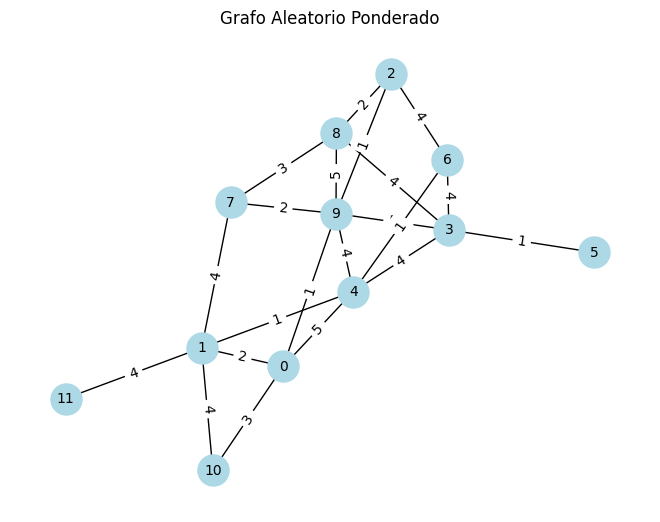

In [3]:
# Dibujar el grafo
pos = nx.spring_layout(G)  # Posiciones de los nodos
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=500, font_size=10)

# Agregar etiquetas de peso a las aristas
edge_labels = nx.get_edge_attributes(G, 'w')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Grafo Aleatorio Ponderado")
plt.show()

2. Definición del valor del corte y de la energía Ising 

    **Función `cut_value`**
    - `G: nx.Graph`: Grafo de entrada
    - `s: np.ndarray`: Arreglo NumPy que representa la partición/spines de nodos
    - `-> float:`: Retorna un float `total`
    - $ cut = \sum_{ij} w_{ij}1 (s_i \neq s_j)$

    **Función `energy_maxcut`**
    - `G: nx.Graph`: Grafo de entrada
    - `s: np.ndarray`: Arreglo NumPy que representa la partición/spines de nodos
    - `-> float:`: Retorna un float `E`
    - $ E(\textbf{s}) = - \sum_{ij} w_{ij} \dfrac{1-s_{ij}}{2}$ 

    De tal manera que:

    `energy_maxcut(G, s)` = `-cut_value(G, s)`

In [4]:

def cut_value(G: nx.Graph, s: np.ndarray) -> float:
    total = 0.0
    for i, j, data in G.edges(data=True):
        w = data["w"]
        if s[i] != s[j]:
            total += w
    return total



def energy_maxcut(G: nx.Graph, s: np.ndarray) -> float:
    E = 0.0
    for i, j, data in G.edges(data=True):
        w = data["w"]
        E += -w * (1 - s[i] * s[j]) / 2.0
    return E

3. Calculo del cambio de energía al voltear un spin 
    - `G: nx.Graph`: Grafo de entrada
    - `s: np.ndarray`: Arreglo NumPy que representa la partición/spines de nodos
    - `i: int`: Índice del nodo que se va a cambiar de grupo 
    - `-> float:`: Retorna un float $\Delta E$
    - $\Delta E_{ij} = -w_{ij}s_is_j$ 

In [5]:
def delta_energy_flip_maxcut(G: nx.Graph, s: np.ndarray, i: int) -> float:
    si = s[i]
    dE = 0.0
    for j in G.neighbors(i):
        w = G[i][j]["w"]
        dE += -w * si * s[j]
    return dE